<a href="https://colab.research.google.com/github/jmestanza/natural-language-processing-practice/blob/main/desafios/Desafio_3/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Desafío 3
Entrenar un modelo de lenguaje basado en caracteres utilizando la [notebook](https://github.com/jmestanza/procesamiento_lenguaje_natural/blob/main/clase_3/ejercicios/3_modelo_lenguaje_char.ipynb) de clase como base .

Objetivos principales
- Comprender el modelo de lenguaje basado en caracteres.
- Definir un corpus para entrenar el modelo.
- Tomar decisiones sobre la arquitectura del modelo.
- Ejecutar el entrenamiento y analizar los resultados.
- Generar secuencias de texto utilizando el modelo entrenado.


Se define un vocabulario de caracteres, incluyendo letras, signos de puntuación y espacios.

Se crean diccionarios de tokenización (carácter a índice y viceversa).

El modelo se entrena en un esquema many-to-many, donde la entrada es una secuencia de caracteres y la salida es la misma secuencia desplazada en un carácter.

Se menciona el uso de capa embedding y time-distributed layers para manejar secuencias.

Generación de texto
Se propone experimentar con diferentes estrategias de generación de secuencias.

Se pueden probar enfoques deterministas o estocásticos para generar texto.

Se debe documentar los resultados de generación obtenidos con el modelo final.

Entrega esperada
Modelo de lenguaje entrenado con la arquitectura seleccionada.

Ejemplos de generación de texto con el modelo.

Reflexión sobre los resultados y ajustes realizados.

En resumen, el trabajo implica entrenar un modelo de lenguaje basado en caracteres, ajustar su arquitectura, medir su rendimiento y generar texto con él.

## Dataset
Originalmente, se había optado por el dataset `THE COMPLETE SHERLOCK HOLMES` que tiene todo el canon de los libros de Arthur Conan Doyle. Pero debido a que es un corpus muy grande  (3868122 de caracteres), la sesión se queda sin ram. Por lo cual se optó por un corpus más chico `The Adventures of Sherlock Holmes` (581565 caracteres).

In [1]:
import os
dataset_path = 'the_adventures_of_sherlock_holmes.txt'
if not os.path.exists(dataset_path):
  # !wget https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/cano.txt
  !wget https://raw.githubusercontent.com/jmestanza/natural-language-processing-practice/refs/heads/main/desafios/Desafio_2/the_adventures_of_sherlock_holmes.txt

In [2]:
with open(dataset_path, 'r') as f:
  text = f.read()

print(len(text))
print(text[:1000])

581565
﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release date: March 1, 1999 [eBook #1661]
                Most recently updated: October 10, 2023

Language: English

Credits: an anonymous Project Gutenberg volunteer and Jose Menendez


*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***




The Adventures of Sherlock Holmes

by Arthur Conan Doyle


Contents

   I.     A Scandal in Bohemia
   II.    The Red-Headed League
   II

## Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus de texto puede ser considerado un documento en sí mismo y el tamaño de contexto puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [3]:
# seleccionamos el tamaño de contexto
max_context_size = 100

# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(text)

# la longitud de vocabulario de caracteres es:
print(len(chars_vocab))

# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}


98


## Tokenizar

In [4]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in text]
tokenized_text[:25]

[33,
 85,
 25,
 10,
 84,
 77,
 80,
 79,
 19,
 10,
 72,
 12,
 84,
 0,
 68,
 12,
 10,
 66,
 22,
 10,
 80,
 27,
 84,
 10,
 89]

## Organizando y estructurando el dataset

In [5]:
import numpy as np
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [6]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [7]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [8]:
X_train = np.array(tokenized_sentences_train[:-1])
y_train = np.array(tokenized_sentences_train[1:])

In [9]:
print(len(tokenized_sentences_val))
print(len(tokenized_sentences_val[0]))

582
0


Nótese que estamos estructurando el problema de aprendizaje como many-to-many:

Entrada: secuencia de tokens $[x_0,x_1, ..., x_n]$

Target: secuencia de tokens $[x_1,x_2, ...,x_{n+1}]$

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como many-to-one en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable tokenized_sentences los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [10]:
X_train.shape

(523265, 100)

In [11]:
X_train[0,:10]

array([33, 85, 25, 10, 84, 77, 80, 79, 19, 10])

In [12]:
y_train[0,:10]

array([85, 25, 10, 84, 77, 80, 79, 19, 10, 72])

In [13]:
vocab_size = len(chars_vocab)
vocab_size

98

## Definiendo el modelo

In [14]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas CategoryEncoding que transforma a índices a vectores OHE y TimeDistributed que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [15]:
model = Sequential([
    Input(shape=(None, 1)),
    TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")),
    SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
    Dense(vocab_size, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 98)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          59,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 98)            │          19,698 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,498 (310.54 KB)

 Trainable params: 79,498 (310.54 KB)

 Non-trainable params: 0 (0.00 B)

## Perplexity callback

Se tuvo que cambiar el enfoque de la implementación del cálculo de perplexity a un enfoque de tipo `batch` ya que la sesión de Colab se terminaba por quedarse sin memoria.

In [16]:
from tensorflow import keras
import time
class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data, history_ppl, patience=5, batch_size=512):
        self.batch_size = batch_size
        self.patience = patience
        self.history_ppl = history_ppl

        self.min_score = np.inf
        self.patience_counter = 0

        # Preprocess and flatten sequences and targets
        self.sequences = []
        self.targets = []
        self.splits = []  # for perplexity aggregation later
        idx = 0

        for seq in val_data:
            if len(seq) <= 1:
                continue
            subseq = [seq[:i] for i in range(1, len(seq))]
            target = [seq[i] for i in range(1, len(seq))]

            self.sequences.extend(subseq)
            self.targets.extend(target)
            self.splits.append((idx, idx + len(subseq)))
            idx += len(subseq)

        self.targets = np.array(self.targets)

    def on_epoch_end(self, epoch, logs=None):
        start_time = time.time()
        print("\nEvaluating perplexity on validation set...")
        preds_all = []

        for i in range(0, len(self.sequences), self.batch_size):
            batch_seqs = self.sequences[i:i+self.batch_size]
            padded = pad_sequences(batch_seqs, maxlen=max_context_size, padding='pre')
            preds = self.model.predict(padded, verbose=0)[:, -1, :]  # last step only
            preds_all.append(preds)

        predictions = np.vstack(preds_all)  # shape (N, vocab_size)

        # Efficient probability lookup
        chosen_probs = predictions[np.arange(len(predictions)), self.targets]
        log_probs = np.log(chosen_probs + 1e-10)  # avoid log(0)

        # Compute mean perplexity per sequence group
        scores = []
        for start, end in self.splits:
            mean_log_prob = np.mean(log_probs[start:end])
            scores.append(np.exp(-mean_log_prob))

        current_score = np.mean(scores)
        self.history_ppl.append(current_score)

        elapsed = time.time() - start_time
        print(f'\nMean Perplexity: {current_score:.4f} | Evaluation Time: {elapsed:.2f} seconds\n')


        # Early stopping logic
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save("my_model.keras")
            print("Saved new best model.")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("Early stopping triggered.")
                self.model.stop_training = True


## Entrenamiento

In [21]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
# batch_size = 512 -> 61 segs perplex calc time
# batch_size = 1024 -> 50 segs perplex calc time
# batch_size = 2048 -> 43 segs perplex calc time
ppl_cb = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl, batch_size=512)
model.fit(X_train, y_train, epochs=1, callbacks=[ppl_cb], batch_size=2048)

255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.8180
Evaluating perplexity on validation set...

Mean Perplexity: 7.6002 | Evaluation Time: 60.79 seconds

Saved new best model.
256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 308ms/step - loss: 1.8180


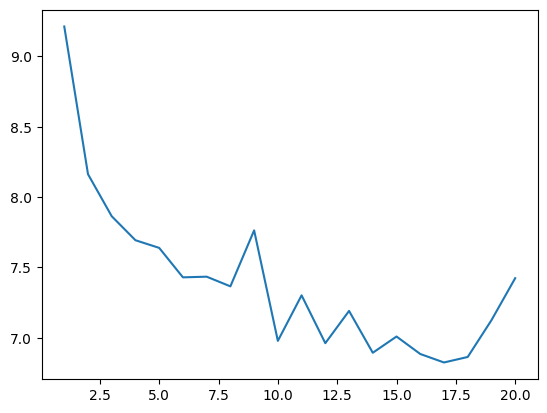

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

## Predicción del próximo caracter

In [ ]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

# iface = gr.Interface(
#     fn=model_response,
#     inputs=["textbox"],
#     outputs="text")

# iface.launch(debug=True)

In [ ]:
model_response('Sherloc')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


'Sherlock'

In [ ]:
model_response('Holme')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


'Holmes'

In [ ]:
model_response('Dr. Watso')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


'Dr. Watson'

In [ ]:
seq = "Sherl"
for i in range(10):
  seq = model_response(seq)
  print(seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Sherlo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Sherloc
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sherlock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sherlock 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sherlock H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sherlock Ha
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sherlock Has
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sherlock Has 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sherlock Has b
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sherlock Has be


In [ ]:
seq = "Dr. Wat"
for i in range(10):
  seq = model_response(seq)
  print(seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Dr. Wats
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Dr. Watso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Dr. Watson
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Dr. Watson,
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Dr. Watson, 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Dr. Watson, t
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Dr. Watson, th
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Dr. Watson, the
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Dr. Watson, the 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Dr. Watson, the c


## Generación de secuencias

In [ ]:

def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text


In [ ]:
input_text='Sherlock'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Sherlock Has been to come to come to c'

In [ ]:
input_text='Dr. Wats'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

'Dr. Watson, the corner of the corner o'